# Image segmentation using FCN-8 decoder

An example of image segmentation of hand written digits using m2nist dataset.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import PIL
import os
import zipfile

## 1. Dataset

### 1.1 Download and unpack the dataset

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip -O /tmp/m2nist.zip

--2023-05-21 19:56:21--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  9.73MB/s    in 1.7s    

2023-05-21 19:56:23 (9.73 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



In [3]:
ZIP_DIR = '/tmp/m2nist.zip'
DATASET_DIR = '/dataset'

with zipfile.ZipFile(ZIP_DIR, 'r') as unpack:
    unpack.extractall(DATASET_DIR)

### 1.2 Load dataset to notebook
Dataset is stored as two Numpy files for images and segmentation masks.
- **Images** 64x84 images with multiple digits.
- **Segmentation** 64x84 images with segmentation masks for 0-9 digits and background.

There are 5000 records total.

In [4]:
def preprocess_dataset(image, mask):

    image = tf.cast(image, dtype='float32')
    image /= 255
    image = tf.expand_dims(image, axis=-1)

    mask = tf.cast(mask, dtype='int32')

    return image, mask


def create_datasets(images_dir, segmentation_dir):

    images = np.load(images_dir)
    segmentation = np.load(segmentation_dir)

    print(f"Images shape: {images.shape}\nSegmentation shape: {segmentation.shape}")

    train_img, val_img, train_seg, val_seg = train_test_split(images, segmentation, test_size=0.2, shuffle=True)
    val_img, test_img, val_seg, test_seg = train_test_split(val_img, val_seg, test_size=0.2, shuffle=True)

    print(f'\nDatasets size:\nTrain: {train_img.shape[0]}\tTest: {test_img.shape[0]}\tVal: {val_img.shape[0]}')

    train_dataset = tf.data.Dataset.from_tensor_slices((train_img, train_seg))
    train_dataset = train_dataset.shuffle(512, reshuffle_each_iteration=True).batch(BATCH_SIZE)
    train_dataset = train_dataset.map(preprocess_dataset)

    test_dataset = tf.data.Dataset.from_tensor_slices((test_img, test_seg))
    test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
    test_dataset = test_dataset.map(preprocess_dataset)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_img, val_seg))
    val_dataset = val_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.map(preprocess_dataset)

    return train_dataset, test_dataset, val_dataset

### 1.3 Create the train, test and validation datasets

In [5]:
IMAGES_DIR = f'{DATASET_DIR}/combined.npy'
SEGMENTATION_DIR = f'{DATASET_DIR}/segmented.npy'
CLASSES_AMOUNT = 11
BATCH_SIZE = 32

print(f"Loading dataset...\nNumber of classes: {CLASSES_AMOUNT}\n")

train_dataset, test_dataset, val_dataset = create_datasets(IMAGES_DIR, SEGMENTATION_DIR)

Loading dataset...
Number of classes: 11

Images shape: (5000, 64, 84)
Segmentation shape: (5000, 64, 84, 11)

Datasets size:
Train: 4000	Test: 200	Val: 800


### 1.4 Preview sample images

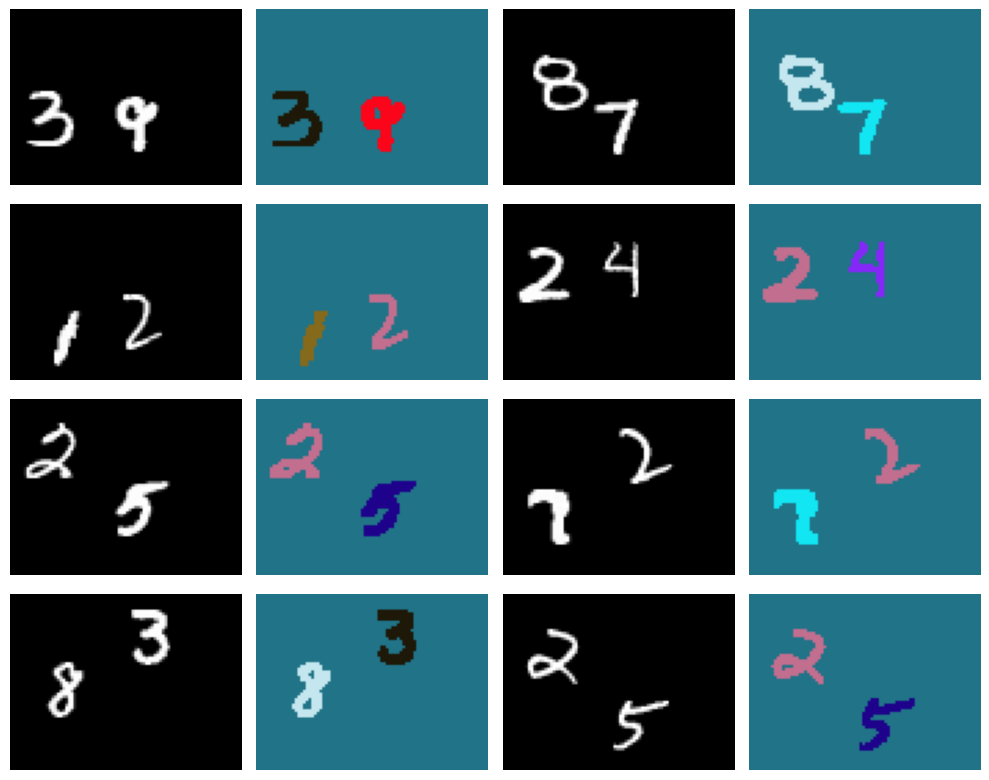

In [6]:
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(CLASSES_AMOUNT)]

def convert_mask_to_image(mask):

    seg_img = np.zeros( (mask.shape[0],mask.shape[1], 3) ).astype('float')

    for c in range(CLASSES_AMOUNT):
        segc = (mask == c)
        seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
        seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
        seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

    return seg_img.astype('uint8')


def preview_dataset(dataset, amount):

    cols = 4
    rows = 2

    fig, axs = plt.subplots(nrows=rows * 2, ncols=cols, figsize=(10, 8))

    for i, data in enumerate(dataset.take(amount)):
        image, mask = data
        merged_mask = np.argmax(mask, axis=3)
        merged_mask = convert_mask_to_image(merged_mask[0])

        img_index = i * 2
        seg_index = img_index + 1

        axs[img_index // cols, img_index % cols].imshow(image[0], cmap='gray')
        axs[img_index // cols, img_index % cols].axis('off')

        axs[seg_index // cols, seg_index % cols].imshow(merged_mask)
        axs[seg_index // cols, seg_index % cols].axis('off')

    fig.tight_layout()
    fig.show()


preview_dataset(train_dataset, amount=8)

## 2. FCN

### 2.1 Downsampling path

**Convolutional block**

It is suggested to initialize weight with He or Xavier initialization when using leaky relu.

In [7]:
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides, index):
    x = tf.keras.layers.Conv2D(filters, 
                               kernel_size, 
                               padding='same', 
                               kernel_initializer='he_normal',
                               data_format=IMAGE_ORDERING)(input)

    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters, 
                               kernel_size, 
                               padding='same',
                               kernel_initializer='he_normal',
                               data_format=IMAGE_ORDERING)(x)
    
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.MaxPooling2D(pooling_size)(x)
    x = tf.keras.layers.BatchNormalization(name=f"END_OF_CONVBLOCK_{index}")(x)

    return x

In [8]:
def FCN8(input_height=64, input_width=84):
    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1))

    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96-input_width)))(img_input)

    x = conv_block(x, filters=32,   kernel_size=3,  pooling_size=2, pool_strides=2, index=1)
    x = conv_block(x, filters=64,   kernel_size=3,  pooling_size=2, pool_strides=2, index=2)
    x = conv_block(x, filters=128,  kernel_size=3,  pooling_size=2, pool_strides=2, index=3)
    f3 = x

    x = conv_block(x, filters=256,  kernel_size=3,  pooling_size=2, pool_strides=2, index=4)
    f4 = x

    x = conv_block(x, filters=256,  kernel_size=3,  pooling_size=2, pool_strides=2, index=5)
    f5 = x
  
    return (f3, f4, f5), img_input

### 2.2 Upsampling path

In [9]:
def FCN8_decoder(convs, n_classes):
    f3, f4, f5 = convs
    n = 512

    x = tf.keras.layers.Conv2D(filters=n, 
                               kernel_size=(7,7), 
                               activation='relu', 
                               padding='same', 
                               name="conv6", 
                               data_format=IMAGE_ORDERING)(f5)

    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(filters=n, 
                               kernel_size=(1, 1),
                               activation='relu',
                               padding='same', 
                               name="conv7", 
                               data_format=IMAGE_ORDERING)(x)

    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(filters=n_classes,  
                               kernel_size=(1, 1), 
                               activation='relu', 
                               padding='same', 
                               data_format=IMAGE_ORDERING)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=n_classes, 
                                        kernel_size=(4,4),  
                                        strides=(2,2), 
                                        data_format=IMAGE_ORDERING,
                                        use_bias=False)(f5)

    x = tf.keras.layers.Cropping2D(cropping=(1,1))(x)

    x2 = f4
    x2 = tf.keras.layers.Conv2D(filters=n_classes, 
                                kernel_size=(1, 1), 
                                activation='relu', 
                                padding='same',
                                data_format=IMAGE_ORDERING)(x2)

    x = tf.keras.layers.Add()([x, x2])

    x = tf.keras.layers.Conv2DTranspose(filters=n_classes, 
                                        kernel_size=(4,4),  
                                        strides=(2,2), 
                                        data_format=IMAGE_ORDERING,
                                        use_bias=False)(x)

    x = tf.keras.layers.Cropping2D(cropping=(1, 1))(x)

    x2 = f3
    x2 = tf.keras.layers.Conv2D(filters=n_classes,
                                kernel_size=(1, 1), 
                                activation='relu', 
                                padding='same', 
                                data_format=IMAGE_ORDERING)(x2)

    x = tf.keras.layers.Add()([x, x2])

    x = tf.keras.layers.Conv2DTranspose(filters=n_classes, 
                                        kernel_size=(8,8),  
                                        strides=(8,8), 
                                        data_format=IMAGE_ORDERING,
                                        use_bias=False)(x)

    x = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(x)

    y = (tf.keras.layers.Activation('sigmoid'))(x)

    return y


### 2.3 Complete model

In [10]:
convs, img_input = FCN8()

decoder = FCN8_decoder(convs, CLASSES_AMOUNT)

model = tf.keras.Model(inputs=img_input, outputs=decoder)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 84, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 64, 96, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 96, 32)   320         ['zero_padding2d[0][0]']         
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 96, 32)   0           ['conv2d[0][0]']                 
                                                                                              

## 3. Train model

### 3.1 Compile the model

In [57]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy', tf.keras.metrics.OneHotIoU(num_classes=CLASSES_AMOUNT, target_class_ids=np.arange(CLASSES_AMOUNT))]
)

### 3.2 Train the model

In [58]:
EPOCHS = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/20
125/125 [==============================] - 13s 50ms/step - loss: 0.0279 - accuracy: 0.9888 - one_hot_io_u_1: 0.8380 - val_loss: 0.0346 - val_accuracy: 0.9871 - val_one_hot_io_u_1: 0.7950
Epoch 2/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0278 - accuracy: 0.9889 - one_hot_io_u_1: 0.8368 - val_loss: 0.0464 - val_accuracy: 0.9839 - val_one_hot_io_u_1: 0.7388
Epoch 3/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0272 - accuracy: 0.9891 - one_hot_io_u_1: 0.8395 - val_loss: 0.0346 - val_accuracy: 0.9870 - val_one_hot_io_u_1: 0.7986
Epoch 4/20
125/125 [==============================] - 6s 47ms/step - loss: 0.0248 - accuracy: 0.9900 - one_hot_io_u_1: 0.8548 - val_loss: 0.0317 - val_accuracy: 0.9882 - val_one_hot_io_u_1: 0.8159
Epoch 5/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0234 - accuracy: 0.9906 - one_hot_io_u_1: 0.8633 - val_loss: 0.0290 - val_accuracy: 0.9891 - val_one_hot_io_u_1: 0.8297
Epoch 6/20
125

### 3.3 Display accuracy and loss plot

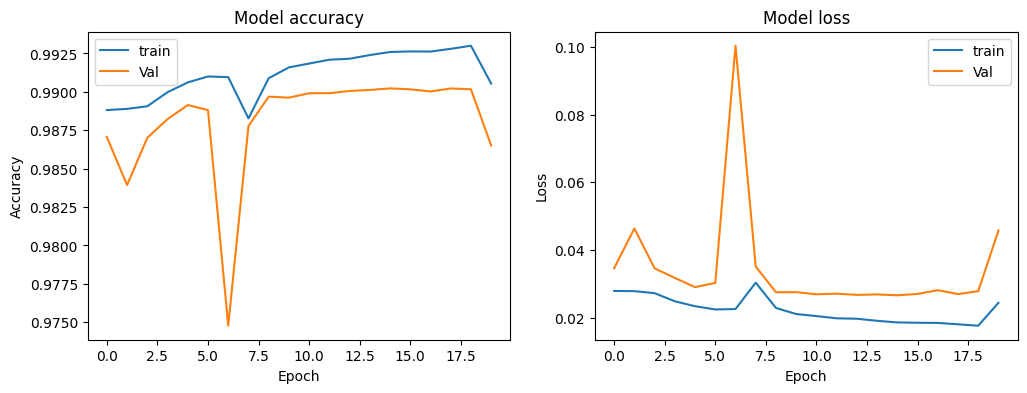

In [206]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title("Model accuracy")
axs[0].plot(history.history["accuracy"])
axs[0].plot(history.history["val_accuracy"])
axs[0].legend(["train", "Val"], loc="upper left")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")

axs[1].set_title("Model loss")
axs[1].plot(history.history["loss"])
axs[1].plot(history.history["val_loss"])
axs[1].legend(["train", "Val"], loc="upper right")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")

fig.show()

## 4. Evaluation

### 4.1 Get the predictions

6/6 [==============================] - 0s 12ms/step
(192, 64, 84, 11)


### 4.2 Get the argmax of segmentation masks


(192, 64, 84)


### 4.3 Intersection over Union (IoU)

In [199]:
iou_metrics = [tf.keras.metrics.OneHotIoU(num_classes=CLASSES_AMOUNT, target_class_ids=[i], name=f"Digit {i}") for i in range(CLASSES_AMOUNT)]

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'] + iou_metrics
)

metrics_eval = model.evaluate(test_dataset)

print(f"\nLoss: {metrics_eval[0]:.4f}\nAccuracy: {metrics_eval[1]:.4f}\n")

for i in range(2,12):
    print(f'Digit {i-2}: {metrics_eval[i]:.4f}')

print(f"\nBackground: {metrics_eval[12]:.4f}")

6/6 [==============================] - 4s 48ms/step - loss: 0.0441 - accuracy: 0.9867 - Digit 0: 0.7989 - Digit 1: 0.8027 - Digit 2: 0.8111 - Digit 3: 0.7790 - Digit 4: 0.7156 - Digit 5: 0.7060 - Digit 6: 0.7058 - Digit 7: 0.8086 - Digit 8: 0.7682 - Digit 9: 0.7218 - Digit 10: 0.9883

Loss: 0.0441
Accuracy: 0.9867

Digit 0: 0.7989
Digit 1: 0.8027
Digit 2: 0.8111
Digit 3: 0.7790
Digit 4: 0.7156
Digit 5: 0.7060
Digit 6: 0.7058
Digit 7: 0.8086
Digit 8: 0.7682
Digit 9: 0.7218

Background: 0.9883


### 4.4 F1 score

**Get the results**

In [207]:
results = model.predict(test_dataset)
print(results.shape)

results = np.argmax(results, axis=3)
print(results.shape)

6/6 [==============================] - 0s 11ms/step
(192, 64, 84, 11)
(192, 64, 84)


**F1 score helper functions**

In [208]:
def get_f1_score(y_true, y_pred, average='binary'):

    unknown_mask = np.logical_or(y_true == -1, y_pred == -1)
    f1 = f1_score(y_true[~unknown_mask], y_pred[~unknown_mask], average=average, zero_division=0)

    return f1


def get_f1_score_per_class(y_true, y_pred, n_classes):

    f1_list = []

    for i in range(n_classes):
        y_true_single_class = (y_true == i)
        y_pred_single_class = (y_pred == i)

        f1 = get_f1_score(y_true_single_class, y_pred_single_class)
        f1_list.append(f1)

    return f1_list

**Calculate the F1 score per digit**
We can see how f1 score performs per class.

In [1]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=3)

f1_per_class = get_f1_score_per_class(y_true, results, CLASSES_AMOUNT-1)
f1_total = get_f1_score(y_true, results, average='macro')

print("f1 score per digit:")

for i in range(CLASSES_AMOUNT-1):
    print(f'Digit {i}\t f1 score: {f1_per_class[i]:.4f}')

print(f'\nTotal f1 score: {f1_total:.4f}')

NameError: ignored

### 4.3 Visualize predictions

In [210]:
def visualize_prediction(image, y_true, y_pred):
    fig, axs = plt.subplots(1,3, figsize=(9,3))
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[1].imshow(y_true)
    axs[1].axis('off')
    axs[2].imshow(y_pred)
    axs[2].axis('off')
    fig.show()

1/1 [==============================] - 0s 226ms/step
Digit 3 F1 score: 0.9147
Digit 7 F1 score: 0.9644


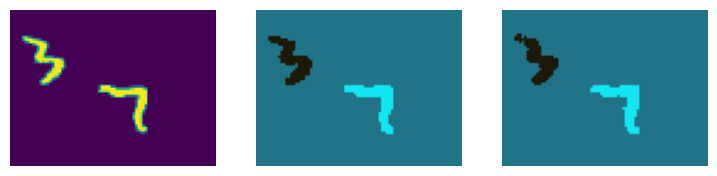

1/1 [==============================] - 0s 23ms/step
Digit 2 F1 score: 0.9348
Digit 4 F1 score: 0.9021


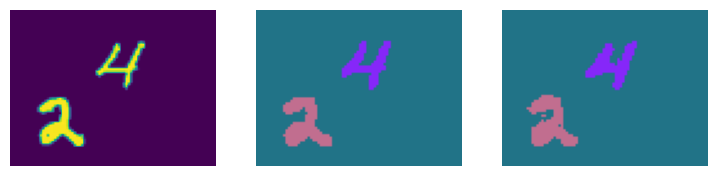

1/1 [==============================] - 0s 26ms/step
Digit 0 F1 score: 0.9551
Digit 9 F1 score: 0.9673


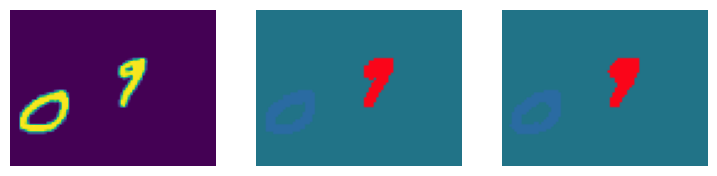

1/1 [==============================] - 0s 23ms/step
Digit 0 F1 score: 0.4889
Digit 4 F1 score: 0.8997


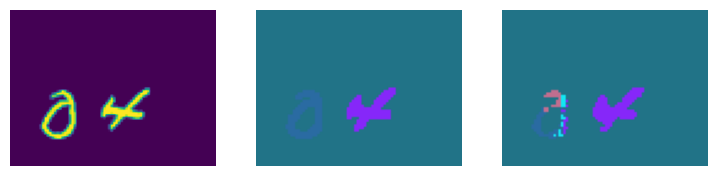

1/1 [==============================] - 0s 27ms/step
Digit 0 F1 score: 0.9375
Digit 1 F1 score: 0.9255


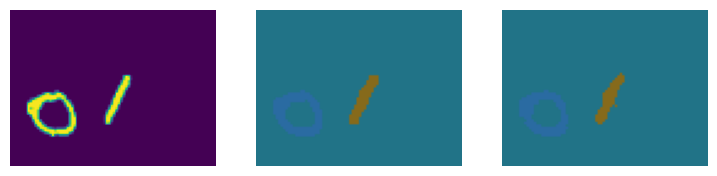

In [211]:
unbatched_test = test_dataset.unbatch()

samples_amount = 10

for img, mask in unbatched_test.take(5):

    pred_img = np.expand_dims(img, axis=0)
    pred = model.predict(pred_img)

    mask = np.argmax(mask, axis=2)
    pred = np.argmax(pred, axis=3)

    f1_per_class = get_f1_score_per_class(mask, np.squeeze(pred), CLASSES_AMOUNT-1)

    mask = np.squeeze(mask)
    pred = np.squeeze(pred)

    for i in range(CLASSES_AMOUNT-1):
        if f1_per_class[i] != 0:
           print(f'Digit {i} F1 score: {f1_per_class[i]:.4f}')

            
    visualize_prediction(img, convert_mask_to_image(mask), convert_mask_to_image(pred))
    plt.pause(0.1)